In [2]:
import sys
sys.path
sys.path.append("/home/haoqi.whq/llm-inference/LoRA")

from src.model import GPT2Config, GPT2LMModel
import torch
from loralib import PruneLayer
import loralib as lora
import math
import importlib

## Load Data

In [3]:
from torch.utils.data import DataLoader
from src.data_utils import FT_Dataset

train_data = "./data/e2e/train.jsonl"
valid_data = "./data/e2e/valid.jsonl"
train_batch_size = 8
valid_batch_size = 4
seq_len = 512
obj = "clm"
random_seed = 888
label_smooth = 0.1

train_data = FT_Dataset(
    train_data, train_batch_size, seq_len, joint_lm=obj == "jlm"
)

valid_data = FT_Dataset(
    valid_data,
    valid_batch_size,
    seq_len,
)

train_loader = DataLoader(
    train_data,
    batch_size=train_batch_size,
    num_workers=0,
    shuffle=False,
    pin_memory=False,
    drop_last=True,
    # sampler=torch.utils.data.distributed.DistributedSampler(
    #     train_data, seed=random_seed
    # ),
)

valid_loader = DataLoader(
    valid_data,
    batch_size=valid_batch_size,
    num_workers=0,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
    # sampler=torch.utils.data.distributed.DistributedSampler(
    #     valid_data, seed=random_seed
    # ),
)

print(type(train_loader))
# data = train_loader[0]

for i, data in enumerate(valid_loader):
    data = {key: value for key, value in data.items()}
    _input = data["input"]
    _target = data["target"]
    _msk = data["mask"]

    print(_input.shape)
    print(_target.shape)
    print(_msk.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4, 512])


## Define and Load Model

In [12]:
# medium GPT2
config = GPT2Config(
    n_embd=1024,
    n_layer=24,
    n_head=16,
    lora_attn_dim=4,
    lora_attn_alpha=32,
    lora_dropout=0.1,
    enable_mlp=True,
    enable_wo=True,
    enable_wq=True,
    enable_wk=True,
    enable_wv=True,
)

lm_net = GPT2LMModel(config)

# summary(lm_net, _input, lm_labels=_target, lm_mask=_msk, label_smooth=label_smooth, depth=6)
# print(lm_net.state_dict())
# transformer.h.0.attn.q_atten.lora_B
# lm_head.decoder.weight
# print("loading model pretrained weight.")
lm_net.load_lora_weight(
    "./pretrained_checkpoints/gpt2-medium-pytorch_model.bin", 
    "./tmp/finetune/qkvom_relu/cp_1e-07/model.cp.lora.26000.pt"
)

O Attention using LoRA: PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
)
MLP using LoRA: PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
), PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
)


In [13]:
for m in lm_net.modules():
    if isinstance(m, PruneLayer):
        print(m, m.complexity(), m.lora_scaling, m.keep_flag)

PruneLinear(
  in_features=1024, out_features=1024, bias=True
  (lora_dropout): Dropout(p=0.1, inplace=False)
) tensor(43094.4375, grad_fn=<MulBackward0>) Parameter containing:
tensor(5.2606, requires_grad=True) True
PruneLinear(
  in_features=1024, out_features=1024, bias=True
  (lora_dropout): Dropout(p=0.1, inplace=False)
) tensor(44939.6914, grad_fn=<MulBackward0>) Parameter containing:
tensor(5.4858, requires_grad=True) True
PruneLinear(
  in_features=1024, out_features=1024, bias=True
  (lora_dropout): Dropout(p=0.1, inplace=False)
) tensor(47108.9805, grad_fn=<MulBackward0>) Parameter containing:
tensor(5.7506, requires_grad=True) True
PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
) tensor(50763.0508, grad_fn=<MulBackward0>) Parameter containing:
tensor(6.1967, requires_grad=True) True
PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
) tensor(114186.0859, grad_fn=<MulBackward0>) Parameter containing:
tensor(5.5755, requires_grad=True) True
PruneG

In [14]:
lm_net.cuda()
# lm_net = torch.nn.DataParallel(lm_net)

lora.mark_only_lora_as_trainable(lm_net)

## Inference

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value
    Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Test Prune LoRA

In [16]:
# lora.prune_lora(lm_net, percent_prune=0.5)

In [17]:
lm_net.eval()
avg_lm_loss = AverageMeter()
activations = {}   # 2
def get_activation(name):   # 3
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

# for name, layer in lm_net.named_modules():   # 4
#     layer.register_forward_hook(get_activation(name))

with torch.no_grad():
    for idx, data in enumerate(valid_loader):
        data = {key: value for key, value in data.items()}

        _input = data["input"].cuda()
        print(_input.shape)
        _target = data["target"].cuda()
        _msk = data["mask"].cuda()

        _lm_logits, _loss = lm_net(_input, lm_labels=_target, lm_mask=_msk)
        print(_lm_logits.shape)
        loss = _loss.mean()

        avg_lm_loss.update(loss.item())

        if idx % 1 == 0:
            print("eval samples:", idx, "loss:", loss.float())
            break

print(avg_lm_loss.avg, math.exp(avg_lm_loss.avg))

torch.Size([4, 512])
hidden states to block: torch.Size([4, 512, 1024]), input_ids: torch.Size([4, 512])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
0-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
0-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
1-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
1-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
2-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
2-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 5

x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
3-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
4-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
4-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
5-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
5-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 4096])
6-fc-act.pt
x:  torch.Size([4, 512, 4096])
torch.Size([4, 512, 1024])
6-proj-act.pt
x:  torch.Size([4, 512, 1024])
torch.Size([4, 512, 1024])
Block:  torch.Size([4, 512, 1024]) torch.Size([4, 512, 1024])
x:  torch.Size([4, 512

/home/haoqi.whq/miniconda3/envs/llm-qd/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


## Illustrate distribution

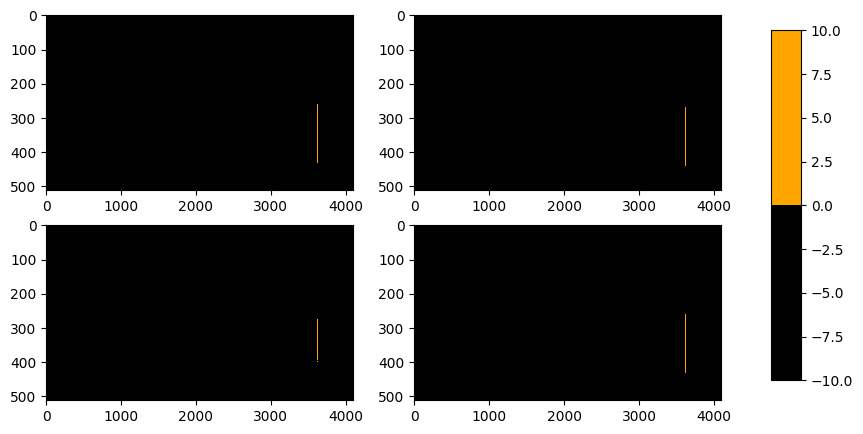

In [4]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm

n_bin = 16
# vmax = 10
# cmap = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

# # Create a custom colormap
# colors = ["white", "black"]
# cmap = ListedColormap(colors)

# cmap = LinearSegmentedColormap.from_list('custom blue', ['blue','lightblue'], N=256)
# cmap.set_over('orange')

# cmap_pos = LinearSegmentedColormap.from_list('custom color', ['white', 'blue'], N=n_bin)

colors = ["black", "orange"]
cmap = ListedColormap(colors)

base_dir = "dist"
n_bins = 20

n_samples = valid_batch_size

norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)
def show(idx, component):
    path = os.path.join(base_dir, f"{idx}-{component}-act.pt")
    data = torch.load(path).cpu()
    assert data.shape[0] == n_samples

    # fig = plt.figure()
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    axes = axes.flatten()
    for i in range(n_samples):
        # plt.subplot(3, 2, i+1)
        # fig.add_subplot(3, 2, i+1)
        im = axes[i].imshow(data[i], cmap=cmap, aspect='auto', norm=norm)
        # cmap = plt.get_cmap('coolwarm')  # 选择颜色映射
        # vmax = torch.max(data[i])  # 数据的最大绝对值
        # vmin = torch.min(data[i])  # 数据的最大绝对值
        # print(vmax, vmin)
        # plt.imshow(data[i], cmap=cmap, aspect='auto', norm=norm)
    
    # fig.add_subplot(3, 2, 5)
    # plt.colorbar()

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.savefig(f"{base_dir}/{idx}-{component}-sparsity.pdf")


show(1, "fc")

2.174860096960275


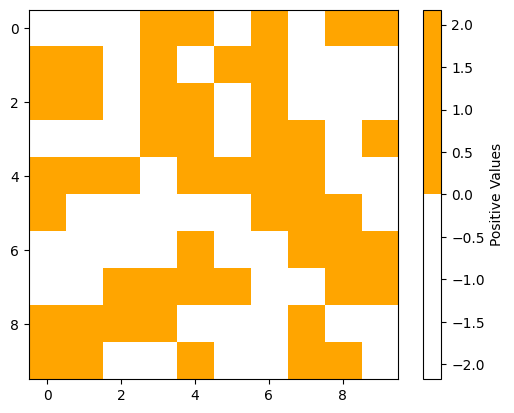

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate sample data
data = np.random.randn(10, 10)  # Replace with your data

# Create a custom colormap
# cmap_neg = mcolors.Normalize(vmin=np.min(data), vmax=0)  # Colormap for negative values
print(np.max(data))
norm = mcolors.Normalize(vmin=-np.max(data), vmax=np.max(data))  # Colormap for positive values

colors = ["white", "orange"]
cmap = ListedColormap(colors)

# Plot the image with the custom colormaps
fig, ax = plt.subplots()
im_pos = ax.imshow(data, cmap=cmap, norm=norm)
plt.colorbar(im_pos, ax=ax, label='Positive Values')
# plt.colorbar(im_neg, ax=ax, label='Negative Values')
plt.show()


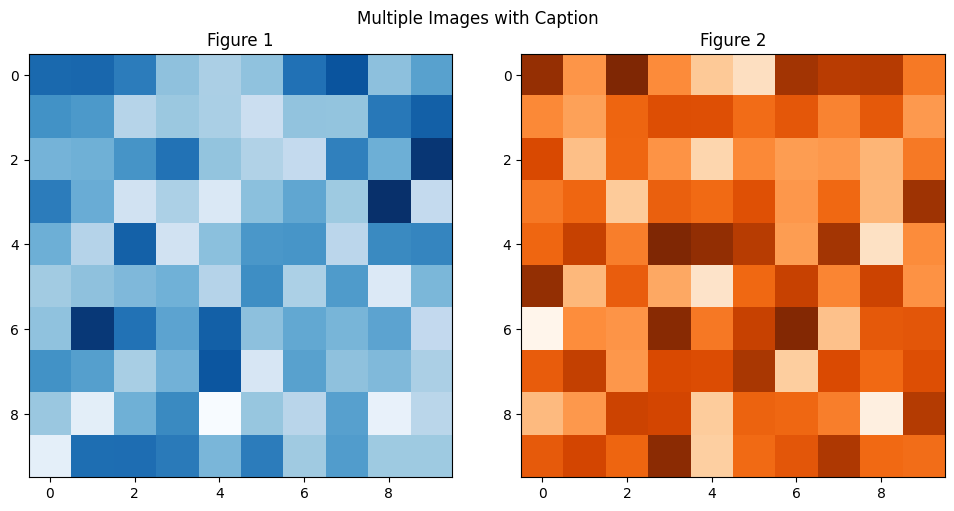

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# 准备数据
data1 = np.random.randn(10, 10)
data2 = np.random.randn(10, 10)

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个子图
axes[0].imshow(data1, cmap='Blues')
axes[0].set_title('Figure 1')

# 绘制第二个子图
axes[1].imshow(data2, cmap='Oranges')
axes[1].set_title('Figure 2')

# 添加共享标题
fig.suptitle('Multiple Images with Caption')

# 调整子图之间的间距
fig.tight_layout()

# 显示图像
plt.show()


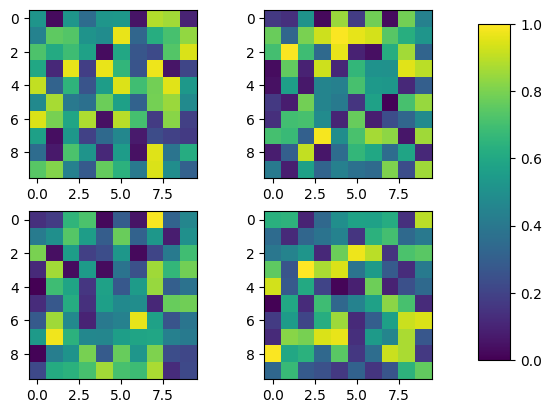

In [102]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()